# Exportando datos

In [36]:
import re
import json
import requests
import pandas as pd
from pathlib import Path
from urllib.parse import urlparse

SOURCE = "/content/drive/MyDrive/TelecomX_Data.json"

OUTPUT_CSV = "TelecomX_Dataframe.csv"

def is_url(s: str) -> bool:
    try:
        r = urlparse(s)
        return r.scheme in ("http", "https")
    except Exception:
        return False

def extract_drive_file_id(url: str) -> str:
    patterns = [
        r"drive\.google\.com/file/d/([a-zA-Z0-9_-]+)",
        r"drive\.google\.com/open\?id=([a-zA-Z0-9_-]+)",
        r"drive\.google\.com/uc\?id=([a-zA-Z0-9_-]+)",
    ]
    for pat in patterns:
        m = re.search(pat, url)
        if m:
            return m.group(1)
    raise ValueError("No se pudo extraer el FILE_ID del enlace de Drive. Verifica el enlace público.")

def build_drive_download_url(file_id: str) -> str:
    return f"https://drive.google.com/uc?export=download&id={file_id}"

def fetch_json_from_url(url: str, timeout: int = 60):

    if "drive.google.com" in url:
        file_id = extract_drive_file_id(url)
        url = build_drive_download_url(file_id)

    resp = requests.get(url, timeout=timeout)
    resp.raise_for_status()
    try:
        return resp.json()
    except requests.JSONDecodeError:
        text = resp.text.strip("\ufeff \n\r\t")
        return json.loads(text)

def load_json_source(source: str):
    if is_url(source):
        return fetch_json_from_url(source)
    else:
        p = Path(source)
        if not p.exists():
            raise FileNotFoundError(f"No se encontró el archivo local: {p}")
        with open(p, "r", encoding="utf-8") as f:
            return json.load(f)

def to_dataframe(data) -> pd.DataFrame:
    if isinstance(data, list):
        return pd.json_normalize(data, sep="_")
    elif isinstance(data, dict):
        if "data" in data and isinstance(data["data"], list):
            return pd.json_normalize(data["data"], sep="_")
        return pd.json_normalize(data, sep="_")
    else:
        raise TypeError(f"Tipo de JSON no soportado: {type(data)}")

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    for c in ["account_Charges_Monthly", "account_Charges_Total"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "Churn" in df.columns:
        df["Churn"] = df["Churn"].replace({"": "Unknown"})
    return df

def main():
    data = load_json_source(SOURCE)
    df_local = to_dataframe(data)
    df_local = clean_dataframe(df_local)

    out_path = Path(OUTPUT_CSV).resolve()
    df_local.to_csv(out_path, index=False, encoding="utf-8")
    print(f"[OK] Filas x columnas: {df_local.shape}")
    print(f"[OK] CSV exportado en: {out_path}")
    print(df_local.head())
    return df_local


df = main()




[OK] Filas x columnas: (7267, 21)
[OK] CSV exportado en: /content/TelecomX_Dataframe.csv
   customerID Churn customer_gender  customer_SeniorCitizen customer_Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer_Dependents  customer_tenure phone_PhoneService phone_MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No    

# Descripción

In [37]:
from IPython.display import display


schema_df = pd.DataFrame({
    "Columna": df.columns,
    "Tipo": [df[c].dtype.name for c in df.columns],
    "% Nulos": (df.isna().mean() * 100).round(2),
    "Únicos": [df[c].nunique(dropna=True) for c in df.columns],
    "Ejemplo": [df[c].dropna().iloc[0] if df[c].notna().any() else None for c in df.columns]
})


orden_tipo = pd.CategoricalDtype(categories=["object", "bool", "int64", "float64"], ordered=True)
schema_df["Tipo_orden"] = schema_df["Tipo"].astype(str).astype(orden_tipo)
schema_df = (schema_df
             .sort_values(by=["Columna"])
             .sort_values(by=["Tipo_orden"])
             .drop(columns="Tipo_orden")
             .reset_index(drop=True))

display(schema_df.style.set_properties(**{"text-align": "left"})
                     .set_table_styles([{"selector": "th", "props": [("text-align", "left")]}]))




_dic = {
    "customerID": "Identificador único del cliente",
    "Churn": "Estado de baja del cliente (Yes/No)",
    "customer_gender": "Género del cliente (Male/Female)",
    "customer_SeniorCitizen": "Adulto mayor (1 = Sí, 0 = No)",
    "customer_Partner": "Tiene pareja (Yes/No)",
    "customer_Dependents": "Tiene dependientes (Yes/No)",
    "customer_tenure": "Meses de permanencia con la compañía",
    "phone_PhoneService": "Servicio telefónico activo (Yes/No)",
    "phone_MultipleLines": "Múltiples líneas telefónicas (Yes/No)",
    "internet_InternetService": "Tipo de internet (DSL/Fiber optic/None)",
    "internet_OnlineSecurity": "Servicio de seguridad en línea (Yes/No)",
    "internet_OnlineBackup": "Servicio de respaldo en línea (Yes/No)",
    "internet_DeviceProtection": "Protección de dispositivos (Yes/No)",
    "internet_TechSupport": "Soporte técnico (Yes/No)",
    "internet_StreamingTV": "Streaming de TV (Yes/No)",
    "internet_StreamingMovies": "Streaming de películas (Yes/No)",
    "account_Contract": "Tipo de contrato (Month-to-month/One/Two year)",
    "account_PaperlessBilling": "Facturación sin papel (Yes/No)",
    "account_PaymentMethod": "Método de pago",
    "account_Charges_Monthly": "Cargos mensuales (numérico)",
    "account_Charges_Total": "Cargos totales acumulados (numérico)"
}

dic_df = (pd.DataFrame(
            [(c, _dic[c]) for c in df.columns if c in _dic],
            columns=["Columna", "Descripción"]
         )
         .sort_values("Columna")
         .reset_index(drop=True))

display(dic_df)

,Columna,Tipo,% Nulos,Únicos,Ejemplo
0,Churn,object,0.000000,3,No
1,internet_TechSupport,object,0.000000,3,Yes
2,internet_StreamingTV,object,0.000000,3,Yes
3,internet_StreamingMovies,object,0.000000,3,No
4,internet_OnlineSecurity,object,0.000000,3,No
5,internet_OnlineBackup,object,0.000000,3,Yes
6,internet_InternetService,object,0.000000,3,DSL
7,internet_DeviceProtection,object,0.000000,3,No
8,phone_MultipleLines,object,0.000000,3,No
9,customer_gender,object,0.000000,2,Female


,Columna,Descripción
0,Churn,Estado de baja del cliente (Yes/No)
1,account_Charges_Monthly,Cargos mensuales (numérico)
2,account_Charges_Total,Cargos totales acumulados (numérico)
3,account_Contract,Tipo de contrato (Month-to-month/One/Two year)
4,account_PaperlessBilling,Facturación sin papel (Yes/No)
5,account_PaymentMethod,Método de pago
6,customerID,Identificador único del cliente
7,customer_Dependents,Tiene dependientes (Yes/No)
8,customer_Partner,Tiene pareja (Yes/No)
9,customer_SeniorCitizen,"Adulto mayor (1 = Sí, 0 = No)"


In [38]:
import numpy as np

relevancia_map = {
    "Churn": "Variable objetivo",
    "customer_tenure": "Antigüedad: menor permanencia suele incrementar churn",
    "account_Contract": "Contrato mensual suele asociarse a mayor churn",
    "account_Charges_Monthly": "Nivel de cargo mensual (sensibilidad al precio)",
    "account_Charges_Total": "Relación valor acumulado vs. permanencia",
    "internet_InternetService": "Tipo/proveedor de internet puede afectar satisfacción",
    "internet_OnlineSecurity": "Servicios adicionales pueden retener clientes",
    "internet_TechSupport": "Soporte técnico se relaciona con satisfacción",
    "customer_SeniorCitizen": "Segmento etario puede mostrar patrones de abandono",
    "customer_Partner": "Variables demográficas pueden correlacionar con churn",
    "customer_Dependents": "Variables demográficas pueden correlacionar con churn",
    "account_PaperlessBilling": "Hábito de facturación puede asociarse a churn",
    "account_PaymentMethod": "Método de pago (facilidad, fricción)",
    "phone_PhoneService": "Bundle de servicios puede reducir churn",
    "phone_MultipleLines": "Bundles y líneas adicionales correlacionan con retención",
    "internet_StreamingTV": "Servicios agregados indican mayor ‘enganche’",
    "internet_StreamingMovies": "Ídem anterior"
}

rel_cols = list(relevancia_map.keys())
relevantes_df = pd.DataFrame({
    "Columna": rel_cols,
    "Motivo": [relevancia_map[c] for c in rel_cols],
    "¿Existe en dataset?": ["Sí" if c in df.columns else "No" for c in rel_cols],
    "Tipo": [df[c].dtype.name if c in df.columns else np.nan for c in rel_cols],
    "Únicos": [df[c].nunique(dropna=True) if c in df.columns else np.nan for c in rel_cols],
})
relevantes_df = relevantes_df.sort_values(["¿Existe en dataset?", "Columna"], ascending=[False, True]).reset_index(drop=True)
display(relevantes_df)


if "Churn" in df.columns:
    churn_flag = df["Churn"].astype(str).str.upper().eq("YES")
    churn_overview = pd.DataFrame({
        "Métrica": ["Clientes totales", "Churn (Yes)", "Churn (No)", "Tasa de churn (Yes)"],
        "Valor": [
            len(df),
            int(churn_flag.sum()),
            int((~churn_flag).sum()),
            churn_flag.mean()
        ]
    })
    churn_overview.loc[churn_overview["Métrica"]=="Tasa de churn (Yes)", "Valor"] = churn_overview.loc[churn_overview["Métrica"]=="Tasa de churn (Yes)", "Valor"].astype(float).round(4)
    display(churn_overview)


    num_cols = [c for c in ["customer_tenure","account_Charges_Monthly","account_Charges_Total"] if c in df.columns]
    if num_cols:
        resumen_num = (
            df.assign(Churn=churn_flag.map({True: "Yes", False: "No"}))
              .groupby("Churn")[num_cols]
              .agg(["count","mean","median","min","max"])
        )

        resumen_num = resumen_num.reindex(columns=num_cols, level=0)

        resumen_num = resumen_num.round(2)
        display(resumen_num)


    cat_cols = [c for c in ["account_Contract","account_PaymentMethod","internet_InternetService"] if c in df.columns]
    tablas_cat = {}
    for c in cat_cols:
        tmp = (df
               .assign(Churn=churn_flag.map({True: "Yes", False: "No"}))
               .groupby(c, dropna=False)
               .agg(Total=("Churn","size"),
                    Churn_Yes=("Churn", lambda s: (s == "Yes").sum()))
               .reset_index())
        tmp["% Churn_Yes"] = (tmp["Churn_Yes"] / tmp["Total"] * 100).round(2)
        tmp = tmp.sort_values(["% Churn_Yes","Total"], ascending=[False, False]).reset_index(drop=True)
        tablas_cat[c] = tmp


    for c, table in tablas_cat.items():
        print(f"\n=== {c} — Frecuencias y %Churn ===")
        display(table)

,Columna,Motivo,¿Existe en dataset?,Tipo,Únicos
0,Churn,Variable objetivo,Sí,object,3
1,account_Charges_Monthly,Nivel de cargo mensual (sensibilidad al precio),Sí,float64,1585
2,account_Charges_Total,Relación valor acumulado vs. permanencia,Sí,float64,6530
3,account_Contract,Contrato mensual suele asociarse a mayor churn,Sí,object,3
4,account_PaperlessBilling,Hábito de facturación puede asociarse a churn,Sí,object,2
5,account_PaymentMethod,"Método de pago (facilidad, fricción)",Sí,object,4
6,customer_Dependents,Variables demográficas pueden correlacionar co...,Sí,object,2
7,customer_Partner,Variables demográficas pueden correlacionar co...,Sí,object,2
8,customer_SeniorCitizen,Segmento etario puede mostrar patrones de aban...,Sí,int64,2
9,customer_tenure,Antigüedad: menor permanencia suele incrementa...,Sí,int64,73


,Métrica,Valor
0,Clientes totales,7267.0000
1,Churn (Yes),1869.0000
2,Churn (No),5398.0000
3,Tasa de churn (Yes),0.2572


customer_tenure                       account_Charges_Monthly         \
                count   mean median min max                   count   mean   
Churn                                                                        
No               5398  37.32   37.0   0  72                    5398  61.35   
Yes              1869  17.98   10.0   1  72                    1869  74.44   

                            account_Charges_Total                           \
      median    min     max                 count     mean   median    min   
Churn                                                                        
No     64.50  18.25  118.75                  5387  2540.44  1669.40  18.80   
Yes    79.65  18.85  118.35                  1869  1531.80   703.55  18.85   

                
           max  
Churn           
No     8672.45  
Yes    8684.80


=== account_Contract — Frecuencias y %Churn ===


,account_Contract,Total,Churn_Yes,% Churn_Yes
0,Month-to-month,4005,1655,41.32
1,One year,1519,166,10.93
2,Two year,1743,48,2.75



=== account_PaymentMethod — Frecuencias y %Churn ===


,account_PaymentMethod,Total,Churn_Yes,% Churn_Yes
0,Electronic check,2445,1071,43.80
1,Mailed check,1665,308,18.50
2,Bank transfer (automatic),1589,258,16.24
3,Credit card (automatic),1568,232,14.80



=== internet_InternetService — Frecuencias y %Churn ===


,internet_InternetService,Total,Churn_Yes,% Churn_Yes
0,Fiber optic,3198,1297,40.56
1,DSL,2488,459,18.45
2,No,1581,113,7.15


# Comprobación de incoherencias en los datos

In [39]:
missing = (df.isna().mean() * 100).round(2)
missing_df = pd.DataFrame({
    "Columna": df.columns,
    "% Nulos": missing
}).sort_values("% Nulos", ascending=False).reset_index(drop=True)

print("=== % DE NULOS POR COLUMNA ===")
display(missing_df)


dup_total = df.duplicated().sum()
dup_id = df.duplicated(subset=["customerID"]).sum() if "customerID" in df.columns else None

print(f"\nFilas duplicadas (exactas): {dup_total}")
if dup_id is not None:
    print(f"Duplicados por customerID: {dup_id}")


num_cols = [c for c in ["customer_tenure","account_Charges_Monthly","account_Charges_Total"] if c in df.columns]
num_summary = df[num_cols].describe().T
num_summary["% negativos"] = [(df[c] < 0).mean()*100 for c in num_cols]
num_summary["% cero"] = [(df[c] == 0).mean()*100 for c in num_cols]

print("\n=== REVISIÓN VARIABLES NUMÉRICAS ===")
display(num_summary.round(2))


cat_expected = {
    "Churn": ["Yes","No","Unknown"],
    "customer_gender": ["Male","Female"],
    "customer_SeniorCitizen": [0,1],
    "customer_Partner": ["Yes","No"],
    "customer_Dependents": ["Yes","No"],
    "phone_PhoneService": ["Yes","No"],
    "phone_MultipleLines": ["Yes","No","No phone service"],
    "internet_InternetService": ["DSL","Fiber optic","No"],
    "internet_OnlineSecurity": ["Yes","No","No internet service"],
    "internet_OnlineBackup": ["Yes","No","No internet service"],
    "internet_DeviceProtection": ["Yes","No","No internet service"],
    "internet_TechSupport": ["Yes","No","No internet service"],
    "internet_StreamingTV": ["Yes","No","No internet service"],
    "internet_StreamingMovies": ["Yes","No","No internet service"],
    "account_Contract": ["Month-to-month","One year","Two year"],
    "account_PaperlessBilling": ["Yes","No"],

}

print("\n=== INCONSISTENCIAS CATEGÓRICAS ===")
for col, expected in cat_expected.items():
    if col in df.columns:
        valores = sorted(df[col].dropna().unique().tolist())
        extra = [v for v in valores if v not in expected]
        if extra:
            print(f"- {col}: Valores inesperados -> {extra}")


=== % DE NULOS POR COLUMNA ===


,Columna,% Nulos
0,account_Charges_Total,0.15
1,Churn,0.00
2,customer_gender,0.00
3,customer_SeniorCitizen,0.00
4,customerID,0.00
5,customer_Partner,0.00
6,customer_Dependents,0.00
7,phone_PhoneService,0.00
8,customer_tenure,0.00
9,internet_InternetService,0.00



Filas duplicadas (exactas): 0
Duplicados por customerID: 0

=== REVISIÓN VARIABLES NUMÉRICAS ===


,count,mean,std,min,25%,50%,75%,max,% negativos,% cero
customer_tenure,7267.0,32.35,24.57,0.00,9.00,29.0,55.00,72.00,0.0,0.15
account_Charges_Monthly,7267.0,64.72,30.13,18.25,35.42,70.3,89.88,118.75,0.0,0.00
account_Charges_Total,7256.0,2280.63,2268.63,18.80,400.22,1391.0,3785.30,8684.80,0.0,0.00



=== INCONSISTENCIAS CATEGÓRICAS ===


# Manejo de inconsistencias

In [40]:
df_clean = df.copy()


if "customerID" in df_clean.columns:
    antes = df_clean.shape[0]
    df_clean = df_clean.drop_duplicates(subset=["customerID"], keep="first")
    despues = df_clean.shape[0]
    print(f"Duplicados por customerID eliminados: {antes - despues}")


for c in ["customer_tenure","account_Charges_Monthly","account_Charges_Total"]:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].fillna(0)


cat_cols = df_clean.select_dtypes(include=["object"]).columns
for c in cat_cols:
    df_clean[c] = df_clean[c].fillna("Unknown")



if "customer_tenure" in df_clean.columns:
    df_clean.loc[df_clean["customer_tenure"] < 0, "customer_tenure"] = 0


for c in ["account_Charges_Monthly","account_Charges_Total"]:
    if c in df_clean.columns:
        df_clean.loc[df_clean[c] < 0, c] = 0


cat_expected = {
    "Churn": ["Yes","No","Unknown"],
    "customer_gender": ["Male","Female"],
    "customer_SeniorCitizen": [0,1],
    "customer_Partner": ["Yes","No"],
    "customer_Dependents": ["Yes","No"],
    "phone_PhoneService": ["Yes","No"],
    "phone_MultipleLines": ["Yes","No","No phone service"],
    "internet_InternetService": ["DSL","Fiber optic","No"],
    "internet_OnlineSecurity": ["Yes","No","No internet service"],
    "internet_OnlineBackup": ["Yes","No","No internet service"],
    "internet_DeviceProtection": ["Yes","No","No internet service"],
    "internet_TechSupport": ["Yes","No","No internet service"],
    "internet_StreamingTV": ["Yes","No","No internet service"],
    "internet_StreamingMovies": ["Yes","No","No internet service"],
    "account_Contract": ["Month-to-month","One year","Two year"],
    "account_PaperlessBilling": ["Yes","No"],
}

for col, expected in cat_expected.items():
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].where(df_clean[col].isin(expected), other="Unknown")


print("\n[OK] Dataset limpio:")
print(df_clean.info())
print(df_clean.head())


Duplicados por customerID eliminados: 0

[OK] Dataset limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   internet_InternetService   7267 non-null   object 
 10  internet_OnlineSecurity    7267 non-null   object 
 11  internet_OnlineBackup      7267 non-null   object 
 12  internet_DeviceProtection  7267 non-null  

# Columna de cuentas diarias

In [41]:
df_clean = df_clean.copy()

if "account_Charges_Monthly" in df_clean.columns:
    df_clean["Cuentas_Diarias"] = (df_clean["account_Charges_Monthly"] / 30).round(2)
    print("[OK] Columna 'Cuentas_Diarias' creada exitosamente.\n")
    print(df_clean[["account_Charges_Monthly","Cuentas_Diarias"]].head(10))
else:
    print("La columna 'account_Charges_Monthly' no existe en el dataset limpio.")


[OK] Columna 'Cuentas_Diarias' creada exitosamente.

   account_Charges_Monthly  Cuentas_Diarias
0                    65.60             2.19
1                    59.90             2.00
2                    73.90             2.46
3                    98.00             3.27
4                    83.90             2.80
5                    69.40             2.31
6                   109.70             3.66
7                    84.65             2.82
8                    48.20             1.61
9                    90.45             3.02


# Estandarización y transformación de datos

In [42]:
df_transf = df_clean.copy()


yes_no_cols = [
    "Churn","customer_Partner","customer_Dependents",
    "phone_PhoneService","phone_MultipleLines",
    "internet_OnlineSecurity","internet_OnlineBackup",
    "internet_DeviceProtection","internet_TechSupport",
    "internet_StreamingTV","internet_StreamingMovies",
    "account_PaperlessBilling"
]

for col in yes_no_cols:
    if col in df_transf.columns:
        df_transf[col] = df_transf[col].map({"Yes":1, "No":0, "Unknown":np.nan, "No phone service":0, "No internet service":0})


rename_map = {
    "customerID": "ID_Cliente",
    "Churn": "BajaCliente",
    "customer_gender": "Genero",
    "customer_SeniorCitizen": "AdultoMayor",
    "customer_Partner": "TienePareja",
    "customer_Dependents": "TieneDependientes",
    "customer_tenure": "Meses_Permanencia",
    "phone_PhoneService": "ServicioTelefonico",
    "phone_MultipleLines": "LineasMultiples",
    "internet_InternetService": "TipoInternet",
    "internet_OnlineSecurity": "SeguridadOnline",
    "internet_OnlineBackup": "RespaldoOnline",
    "internet_DeviceProtection": "ProteccionDispositivo",
    "internet_TechSupport": "SoporteTecnico",
    "internet_StreamingTV": "StreamingTV",
    "internet_StreamingMovies": "StreamingPeliculas",
    "account_Contract": "TipoContrato",
    "account_PaperlessBilling": "FacturaSinPapel",
    "account_PaymentMethod": "MetodoPago",
    "account_Charges_Monthly": "CargoMensual",
    "account_Charges_Total": "CargoTotal",
    "Cuentas_Diarias": "CargoDiario"
}
df_transf = df_transf.rename(columns=rename_map)


print("[OK] Transformación completada.")
print(df_transf.head())


[OK] Transformación completada.
   ID_Cliente  BajaCliente  Genero  AdultoMayor  TienePareja  \
0  0002-ORFBO          0.0  Female            0          1.0   
1  0003-MKNFE          0.0    Male            0          0.0   
2  0004-TLHLJ          1.0    Male            0          0.0   
3  0011-IGKFF          1.0    Male            1          1.0   
4  0013-EXCHZ          1.0  Female            1          1.0   

   TieneDependientes  Meses_Permanencia  ServicioTelefonico  LineasMultiples  \
0                1.0                  9                 1.0              0.0   
1                0.0                  9                 1.0              1.0   
2                0.0                  4                 1.0              0.0   
3                0.0                 13                 1.0              0.0   
4                0.0                  3                 1.0              0.0   

  TipoInternet  ...  ProteccionDispositivo  SoporteTecnico  StreamingTV  \
0          DSL  ...        

# Análisis Descriptivo

In [43]:

num_cols = df_transf.select_dtypes(include=["int64","float64"]).columns
stats_global = df_transf[num_cols].describe().T
stats_global["varianza"] = df_transf[num_cols].var()
stats_global["desv_estandar"] = df_transf[num_cols].std()
stats_global = stats_global.round(2)

print("=== ESTADÍSTICAS GLOBALES DE VARIABLES NUMÉRICAS ===")
display(stats_global)

if "BajaCliente" in df_transf.columns:
    stats_por_churn = (
        df_transf.groupby("BajaCliente")[num_cols]
        .agg(["mean","median","std","min","max","count"])
        .round(2)
    )
    print("\n=== ESTADÍSTICAS NUMÉRICAS POR CHURN ===")
    display(stats_por_churn)


cat_cols = ["Genero","TipoContrato","TipoInternet","MetodoPago"]
for c in cat_cols:
    if c in df_transf.columns:
        tabla = (
            df_transf.groupby([c,"BajaCliente"])
            .size()
            .unstack(fill_value=0)
        )
        tabla["Total"] = tabla.sum(axis=1)
        tabla["% Churn"] = (tabla[1] / tabla["Total"] * 100).round(2) if 1 in tabla.columns else 0
        print(f"\n=== FRECUENCIA Y % CHURN POR {c.upper()} ===")
        display(tabla.sort_values("% Churn", ascending=False))


=== ESTADÍSTICAS GLOBALES DE VARIABLES NUMÉRICAS ===


,count,mean,std,min,25%,50%,75%,max,varianza,desv_estandar
BajaCliente,7043.0,0.27,0.44,0.00,0.00,0.00,1.00,1.00,0.19,0.44
AdultoMayor,7267.0,0.16,0.37,0.00,0.00,0.00,0.00,1.00,0.14,0.37
TienePareja,7267.0,0.48,0.50,0.00,0.00,0.00,1.00,1.00,0.25,0.50
TieneDependientes,7267.0,0.30,0.46,0.00,0.00,0.00,1.00,1.00,0.21,0.46
Meses_Permanencia,7267.0,32.35,24.57,0.00,9.00,29.00,55.00,72.00,603.77,24.57
ServicioTelefonico,7267.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00,0.09,0.30
LineasMultiples,7267.0,0.42,0.49,0.00,0.00,0.00,1.00,1.00,0.24,0.49
SeguridadOnline,7267.0,0.29,0.45,0.00,0.00,0.00,1.00,1.00,0.20,0.45
RespaldoOnline,7267.0,0.34,0.48,0.00,0.00,0.00,1.00,1.00,0.23,0.48
ProteccionDispositivo,7267.0,0.34,0.47,0.00,0.00,0.00,1.00,1.00,0.23,0.47



=== ESTADÍSTICAS NUMÉRICAS POR CHURN ===


BajaCliente                             AdultoMayor               \
                   mean median  std  min  max count        mean median   std   
BajaCliente                                                                    
0.0                 0.0    0.0  0.0  0.0  0.0  5174        0.13    0.0  0.33   
1.0                 1.0    1.0  0.0  1.0  1.0  1869        0.25    0.0  0.44   

                 ... CargoTotal                       CargoDiario         \
            min  ...        std    min      max count        mean median   
BajaCliente      ...                                                       
0.0           0  ...    2329.95   0.00  8672.45  5174        2.04   2.15   
1.0           0  ...    1890.82  18.85  8684.80  1869        2.48   2.66   

                                     
              std   min   max count  
BajaCliente                          
0.0          1.04  0.61  3.96  5174  
1.0          0.82  0.63  3.94  1869  

[2 rows x 102 columns]


=== FRECUENCIA Y % CHURN POR GENERO ===


BajaCliente,0.0,1.0,Total,% Churn
Genero,,,,
Female,2549,939,3488,26.92
Male,2625,930,3555,26.16



=== FRECUENCIA Y % CHURN POR TIPOCONTRATO ===


BajaCliente,0.0,1.0,Total,% Churn
TipoContrato,,,,
Month-to-month,2220,1655,3875,42.71
One year,1307,166,1473,11.27
Two year,1647,48,1695,2.83



=== FRECUENCIA Y % CHURN POR TIPOINTERNET ===


BajaCliente,0.0,1.0,Total,% Churn
TipoInternet,,,,
Fiber optic,1799,1297,3096,41.89
DSL,1962,459,2421,18.96
No,1413,113,1526,7.40



=== FRECUENCIA Y % CHURN POR METODOPAGO ===


BajaCliente,0.0,1.0,Total,% Churn
MetodoPago,,,,
Electronic check,1294,1071,2365,45.29
Mailed check,1304,308,1612,19.11
Bank transfer (automatic),1286,258,1544,16.71
Credit card (automatic),1290,232,1522,15.24


# Distribución de evasión

/tmp/ipython-input-18972445.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=churn_col, data=df_transf, palette="Set2")


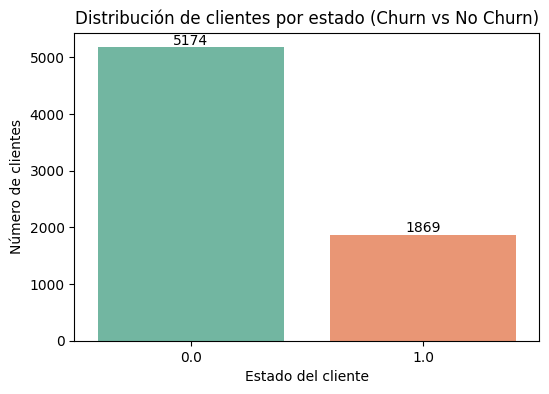

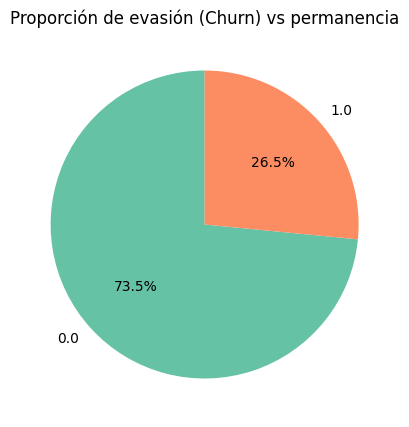

=== Distribución porcentual de churn ===
BajaCliente
0.0    73.46
1.0    26.54
Name: proportion, dtype: float64


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns


if "BajaCliente" not in df_transf.columns and "Churn" in df_transf.columns:
    churn_col = "Churn"
else:
    churn_col = "BajaCliente"


plt.figure(figsize=(6,4))
ax = sns.countplot(x=churn_col, data=df_transf, palette="Set2")
plt.title("Distribución de clientes por estado (Churn vs No Churn)")
plt.xlabel("Estado del cliente")
plt.ylabel("Número de clientes")


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')
plt.show()


prop = df_transf[churn_col].value_counts(normalize=True) * 100

plt.figure(figsize=(5,5))
plt.pie(prop, labels=prop.index, autopct="%.1f%%", startangle=90, colors=sns.color_palette("Set2"))
plt.title("Proporción de evasión (Churn) vs permanencia")
plt.show()

print("=== Distribución porcentual de churn ===")
print(prop.round(2))


# Recuento de evasión por variables categóricas

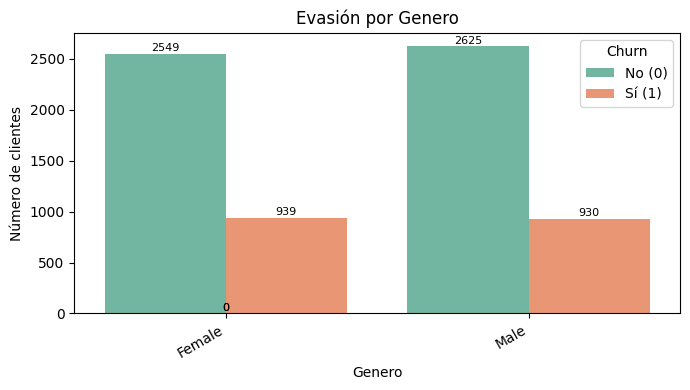


=== Tabla de Genero vs Churn ===


BajaCliente,0.0,1.0,Total,%Churn
Genero,,,,
Female,2549,939,3488,26.92
Male,2625,930,3555,26.16


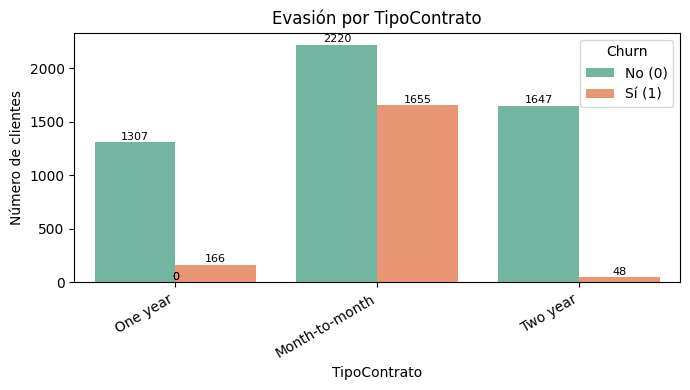


=== Tabla de TipoContrato vs Churn ===


BajaCliente,0.0,1.0,Total,%Churn
TipoContrato,,,,
Month-to-month,2220,1655,3875,42.71
One year,1307,166,1473,11.27
Two year,1647,48,1695,2.83


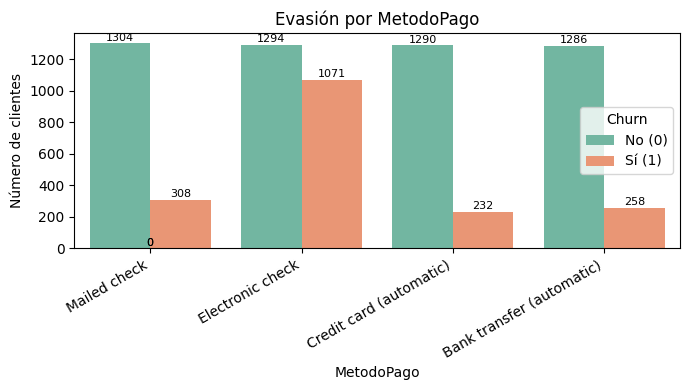


=== Tabla de MetodoPago vs Churn ===


BajaCliente,0.0,1.0,Total,%Churn
MetodoPago,,,,
Electronic check,1294,1071,2365,45.29
Mailed check,1304,308,1612,19.11
Bank transfer (automatic),1286,258,1544,16.71
Credit card (automatic),1290,232,1522,15.24


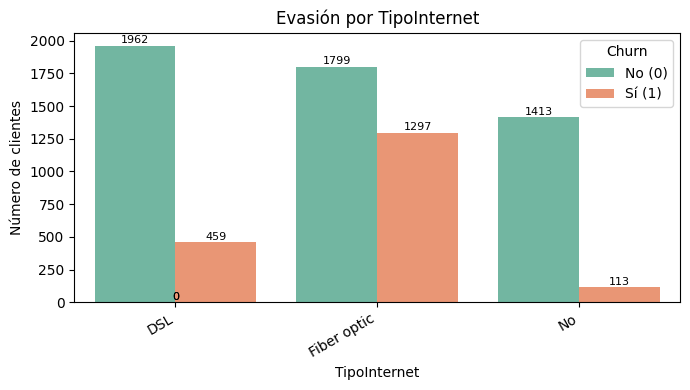


=== Tabla de TipoInternet vs Churn ===


BajaCliente,0.0,1.0,Total,%Churn
TipoInternet,,,,
Fiber optic,1799,1297,3096,41.89
DSL,1962,459,2421,18.96
No,1413,113,1526,7.40


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

churn_col = "BajaCliente" if "BajaCliente" in df_transf.columns else "Churn"


cat_vars = ["Genero", "TipoContrato", "MetodoPago", "TipoInternet"]

for col in cat_vars:
    if col in df_transf.columns:
        plt.figure(figsize=(7,4))
        ax = sns.countplot(x=col, hue=churn_col, data=df_transf, palette="Set2")
        plt.title(f"Evasión por {col}")
        plt.xlabel(col)
        plt.ylabel("Número de clientes")
        plt.xticks(rotation=30, ha="right")


        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8, color='black',
                        xytext=(0, 4), textcoords='offset points')
        plt.legend(title="Churn", labels=["No (0)","Sí (1)"] if df_transf[churn_col].dropna().isin([0,1]).all() else None)
        plt.tight_layout()
        plt.show()


        tabla = (
            df_transf.groupby([col, churn_col])
            .size()
            .unstack(fill_value=0)
        )
        tabla["Total"] = tabla.sum(axis=1)
        if 1 in tabla.columns:
            tabla["%Churn"] = (tabla[1] / tabla["Total"] * 100).round(2)
        elif "Yes" in tabla.columns:
            tabla["%Churn"] = (tabla["Yes"] / tabla["Total"] * 100).round(2)
        print(f"\n=== Tabla de {col} vs Churn ===")
        display(tabla.sort_values("%Churn", ascending=False))




# Conteo de evasión por variables numéricas


/tmp/ipython-input-2515098703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=churn_col, y=col, data=df_transf, palette="Set2")


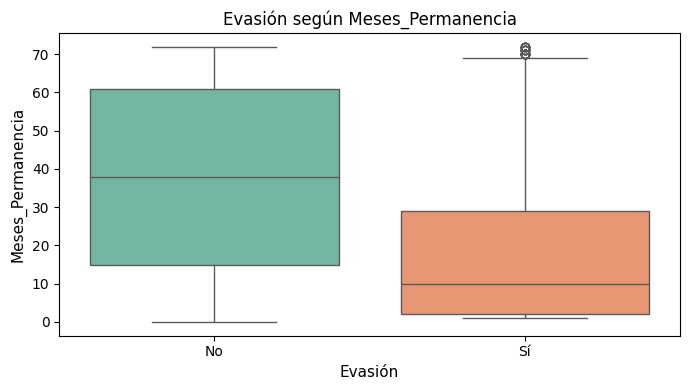


=== Estadísticas de Meses_Permanencia por evasión ===


,count,mean,median,std,min,max
BajaCliente,,,,,,
0.0,5174,37.57,38.0,24.11,0,72
1.0,1869,17.98,10.0,19.53,1,72


/tmp/ipython-input-2515098703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=churn_col, y=col, data=df_transf, palette="Set2")


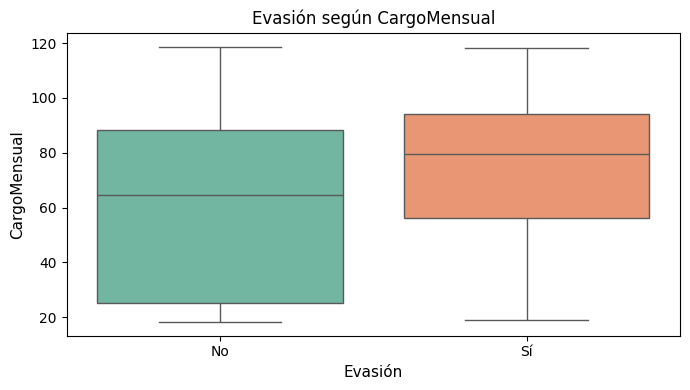


=== Estadísticas de CargoMensual por evasión ===


,count,mean,median,std,min,max
BajaCliente,,,,,,
0.0,5174,61.27,64.43,31.09,18.25,118.75
1.0,1869,74.44,79.65,24.67,18.85,118.35


/tmp/ipython-input-2515098703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=churn_col, y=col, data=df_transf, palette="Set2")


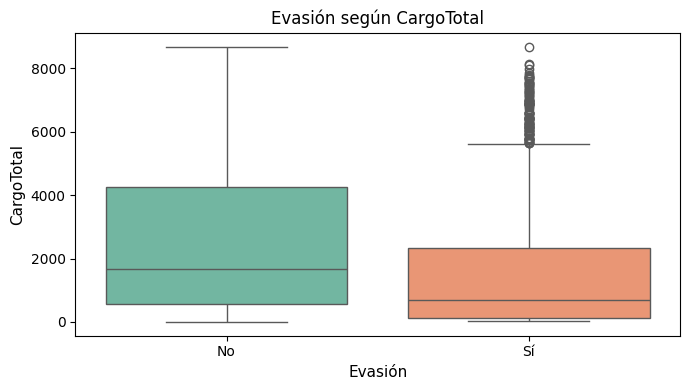


=== Estadísticas de CargoTotal por evasión ===


,count,mean,median,std,min,max
BajaCliente,,,,,,
0.0,5174,2549.91,1679.52,2329.95,0.00,8672.45
1.0,1869,1531.80,703.55,1890.82,18.85,8684.80


/tmp/ipython-input-2515098703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=churn_col, y=col, data=df_transf, palette="Set2")


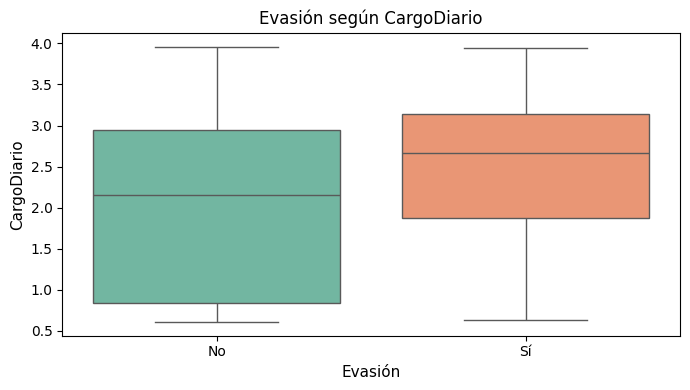


=== Estadísticas de CargoDiario por evasión ===


,count,mean,median,std,min,max
BajaCliente,,,,,,
0.0,5174,2.04,2.15,1.04,0.61,3.96
1.0,1869,2.48,2.66,0.82,0.63,3.94


In [46]:
churn_col = "BajaCliente" if "BajaCliente" in df_transf.columns else "Churn"


num_vars = ["Meses_Permanencia","CargoMensual","CargoTotal","CargoDiario"]

for col in num_vars:
    if col in df_transf.columns:
        plt.figure(figsize=(7,4))
        sns.boxplot(x=churn_col, y=col, data=df_transf, palette="Set2")
        plt.title(f"Evasión según {col}", fontsize=12)
        plt.xlabel("Evasión", fontsize=11)
        plt.ylabel(col, fontsize=11)
        plt.xticks(ticks=[0,1], labels=["No","Sí"]) if df_transf[churn_col].dropna().isin([0,1]).all() else None
        plt.tight_layout()
        plt.show()


        resumen = (
            df_transf.groupby(churn_col)[col]
            .agg(["count","mean","median","std","min","max"])
            .round(2)
        )
        print(f"\n=== Estadísticas de {col} por evasión ===")
        display(resumen)


# Informe


# Informe de Evasión de Clientes (Churn)

**Objetivo:** Analizar el comportamiento de evasión de clientes para identificar patrones y oportunidades de intervención.  

**Tamaño del dataset:** 7,267 filas × 23 columnas.  
**Tasa global de evasión:** 25.72%.



## Limpieza y Tratamiento de Datos

- Se manejaron valores ausentes.  
- Se corrigieron categorías inválidas (`Unknown`).  
- Se derivó la columna **CargoDiario** a partir de CargoMensual.  
- Se estandarizó la variable de churn a bandera Sí/No.  



## Análisis Exploratorio de Datos

- Distribución de evasión (Sí/No).  
- Relación de churn con permanencia y cargos.  
- Exploración de variables categóricas (Contrato, Método de pago, Internet).  



## Conclusiones e Insights

- La evasión global ronda el **25.72%**.  
- Los clientes con **menor permanencia** presentan mayor propensión a cancelar el servicio.  
- Los contratos **Month-to-month** muestran tasas de evasión significativamente más altas.  
- Los clientes con **cargos mensuales más elevados** tienen mayor tendencia a la evasión.  

👉 Estos hallazgos ayudan a identificar perfiles de riesgo y diseñar estrategias específicas para **retener clientes**.



## Recomendaciones

- **Retención temprana:** implementar campañas de bienvenida y seguimiento en los primeros meses.  
- **Incentivos de permanencia:** fomentar la migración a contratos anuales/bianuales mediante descuentos o beneficios.  
- **Optimización de precios:** revisar la estructura de cargos mensuales y ofrecer paquetes/bundles que aporten mayor valor.  
- **Alertas de churn:** activar sistemas de scoring que prioricen clientes en riesgo para atención proactiva.  


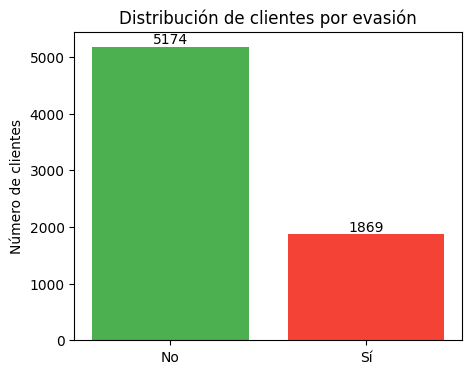

<Figure size 500x400 with 0 Axes>

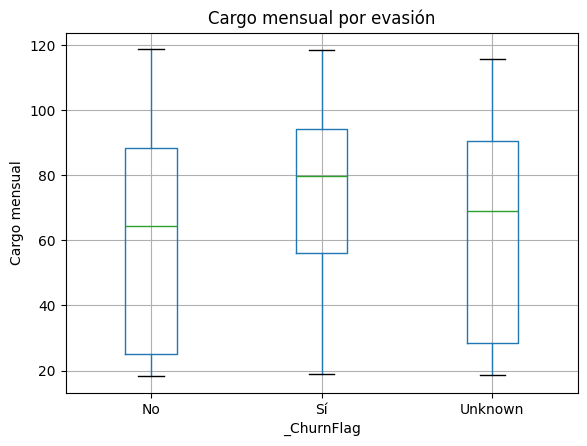

In [47]:
df_any = df_clean.copy() if "df_clean" in globals() else df.copy()
churn_col = "BajaCliente" if "BajaCliente" in df_any.columns else "Churn"
df_any["_ChurnFlag"] = df_any[churn_col].replace({1:"Sí",0:"No","Yes":"Sí","No":"No"})


n_rows, n_cols = df_any.shape
churn_rate = (df_any["_ChurnFlag"]=="Sí").mean()


intro = f"""
# Informe de Evasión de Clientes (Churn)

**Objetivo:** Analizar el comportamiento de evasión de clientes para identificar patrones y oportunidades de intervención.

**Tamaño del dataset:** {n_rows:,} filas × {n_cols} columnas.
**Tasa global de evasión:** {churn_rate:.2%}.
"""

limpieza = """
## Limpieza y Tratamiento de Datos

- Se manejaron valores ausentes.
- Se corrigieron categorías inválidas (`Unknown`).
- Se derivó la columna **CargoDiario** a partir de CargoMensual.
- Se estandarizó la variable de churn a bandera Sí/No.
"""

eda = """
## Análisis Exploratorio de Datos

- Distribución de evasión (Sí/No).
- Relación de churn con permanencia y cargos.
- Exploración de variables categóricas (Contrato, Método de pago, Internet).
"""

conclusiones = f"""
## Conclusiones e Insights

- La evasión global ronda el **{churn_rate:.2%}**.
- Los clientes con **menor permanencia** presentan mayor propensión a cancelar el servicio.
- Los contratos **Month-to-month** muestran tasas de evasión significativamente más altas.
- Los clientes con **cargos mensuales más elevados** tienen mayor tendencia a la evasión.

👉 Estos hallazgos ayudan a identificar perfiles de riesgo y diseñar estrategias específicas para **retener clientes**.
"""

recomendaciones = """
## Recomendaciones

- **Retención temprana:** implementar campañas de bienvenida y seguimiento en los primeros meses.
- **Incentivos de permanencia:** fomentar la migración a contratos anuales/bianuales mediante descuentos o beneficios.
- **Optimización de precios:** revisar la estructura de cargos mensuales y ofrecer paquetes/bundles que aporten mayor valor.
- **Alertas de churn:** activar sistemas de scoring que prioricen clientes en riesgo para atención proactiva.
"""


for section in [intro, limpieza, eda, conclusiones, recomendaciones]:
    display(Markdown(section))


counts = df_any["_ChurnFlag"].value_counts().reindex(["No","Sí"]).fillna(0)
plt.figure(figsize=(5,4))
plt.bar(counts.index, counts.values, color=["#4CAF50","#F44336"])
plt.title("Distribución de clientes por evasión")
plt.ylabel("Número de clientes")
for i, v in enumerate(counts.values):
    plt.text(i, v, str(int(v)), ha="center", va="bottom")
plt.show()


if "Meses_Permanencia" in df_any.columns:
    plt.figure(figsize=(5,4))
    df_any.boxplot(column="Meses_Permanencia", by="_ChurnFlag")
    plt.title("Meses de permanencia por evasión")
    plt.suptitle("")
    plt.ylabel("Meses")
    plt.show()


if "CargoMensual" in df_any.columns or "account_Charges_Monthly" in df_any.columns:
    col = "CargoMensual" if "CargoMensual" in df_any.columns else "account_Charges_Monthly"
    plt.figure(figsize=(5,4))
    df_any.boxplot(column=col, by="_ChurnFlag")
    plt.title("Cargo mensual por evasión")
    plt.suptitle("")
    plt.ylabel("Cargo mensual")
    plt.show()


